### Code execution and intended outcome
This notebook generates a visualization of attention maps across ViT layers for distinct $\lambda$ values in FAX loss similar to Figure 5. We use a data sample from the DR(eye)VE dataset. The same plot can be generated in similar fashion.

### Preliminary step
* Before generating the plot, ensure at least one full training run of the 12-layer baseline ViT model has been completed for each $\lambda$ value. A
* Since you want to load ViT models trained with FAX loss, you need to change the code ViT code inside timm library (`https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py`) with the code in the file `fixatt/training/vision_transformer_modified_for_fax_loss.py` and load the modified timm library.



In [7]:
# Imports
import torch
import timm
import random
import sys
import random
import numpy as np
import torch.nn as nn
from pathlib import Path
import nopdb
import matplotlib.pyplot as plt


sys.path.append('../training')  # This adds the parent directory to the system path
from utils import *
from dataloaders import *

In [6]:
classes = ['left','right']

def predict(model, input, fixation, cpu=False, verbose=False):
    """Run the model on an input and print the predicted classes with probabilities."""
    with torch.no_grad():
        if cpu:
            [logits], _ = model.to(device)(input[None], fixation[None])
        else:
            [logits], _ = model(input[None], fixation[None])
        probs = torch.softmax(logits, dim=0)
        topk_prob, topk_id = torch.topk(probs, len(classes))
        if verbose:
            for i in range(topk_prob.size(0)):
                print(classes[topk_id[i]], topk_prob[i].item(), sep="\t")
        return topk_prob, topk_id


normalize_image_arr = lambda x: (x - np.min(x)) / np.ptp(x)

In [ ]:
# Load test data
model_type = 'fax'
dataset_type    = 'dreyeve' # 'vr' or 'dreyeve'
run             = 3

train_data_cond = 'full'
test_data_cond = 'full'
data_path       = 'fixatt/data' #path to dataset
vit_version     = 'vit_base_patch16_224'
model_load_type = 'early_stopped'
validation      = True
batch_size      = 16
device          = torch.device("cuda:1")


random_state = run
if random_state:
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

train_list, valid_list, test_list = get_split_data(dataset_type, data_path, train_data_cond, dataset_type, validation, random_state)
train_loader, valid_loader, test_loader, train_data, valid_data, test_data = get_loaders(dataset_type, model_type, train_list, valid_list, test_list, 
                                                                                        batch_size, train_data_cond, test_data_cond)

### Print the average attention map across all heads of a specific layer

In [ ]:
'''Create 'attention_maps': list containing 6 arrays of shape (12, 14, 14) corresponding to
                             6 lambda values [0, 0.01, 0.1, 0.2, 0.8, 1]. The first dimension 
                             of these arrays correspond to the number of layers of the ViT 
                             model and (14, 14) is the size of attention maps.
'''
test_idx = 0
x, fixation, label = test_data.__getitem__(test_idx) # get one sample from dataset


# Create a list called 'paths' which include the paths of the 
# trained models for different lambda values = {0, 0.01, 0.1, 0.2, 0.8, 1, etc.}
trained_models_path = 'fixatt/training/pre_trained_models' # path to trained models
paths = [
    'dreyeve_full_vit/trained_LR_driving_2_False_layer_None_lambda_early_stopped',
    'dreyeve_full_fax/trained_LR_driving_9_False_layer_0.01_lambda_early_stopped',
    'dreyeve_full_fax/trained_LR_driving_5_False_layer_0.1_lambda_early_stopped',
    'dreyeve_full_fax/trained_LR_driving_4_False_layer_0.2_lambda_early_stopped',
    'dreyeve_full_fax/trained_LR_driving_0_False_layer_0.8_lambda_early_stopped',
    'dreyeve_full_fax/trained_LR_driving_3_False_layer_1_lambda_early_stopped'
]
                

attention_maps = []
head_num = 9 # which of the 12 heads to plot
for path in paths:
    model = timm.create_model(vit_version, num_classes=2).to(device)
    model.load_state_dict(torch.load(f'{trained_models_path}/{path}.pt'))

    head_list = []

    for layer in range(len(model.blocks)):
        with nopdb.capture_call(model.blocks[layer].attn.forward) as attn_call:
                predict(model, x.to(device), fixation.to(device))

        data = attn_call.locals['attn'][0].mean(dim=1) # Take the average across all heads
        data = data.cpu()
        data = data.mean(axis=-2)  # Average over all attention keys, ie. average over every column of the attn map
        data = data[1:]  # Skip the [CLS] token
        data = torch.reshape(data, (14, 14))
        data = np.array(data)                
        data = normalize_image_arr(data)
        head_list.append(data)
    head_list = np.array(head_list)
    attention_maps.append(head_list)

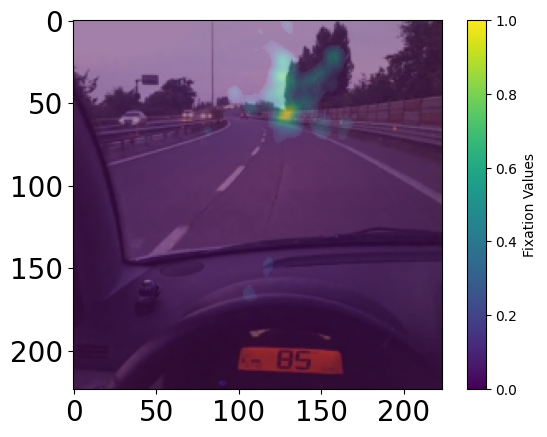

<Figure size 640x480 with 0 Axes>

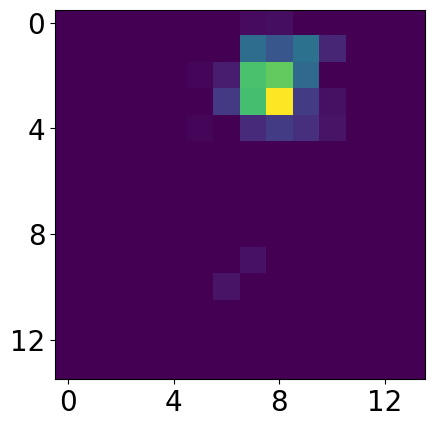

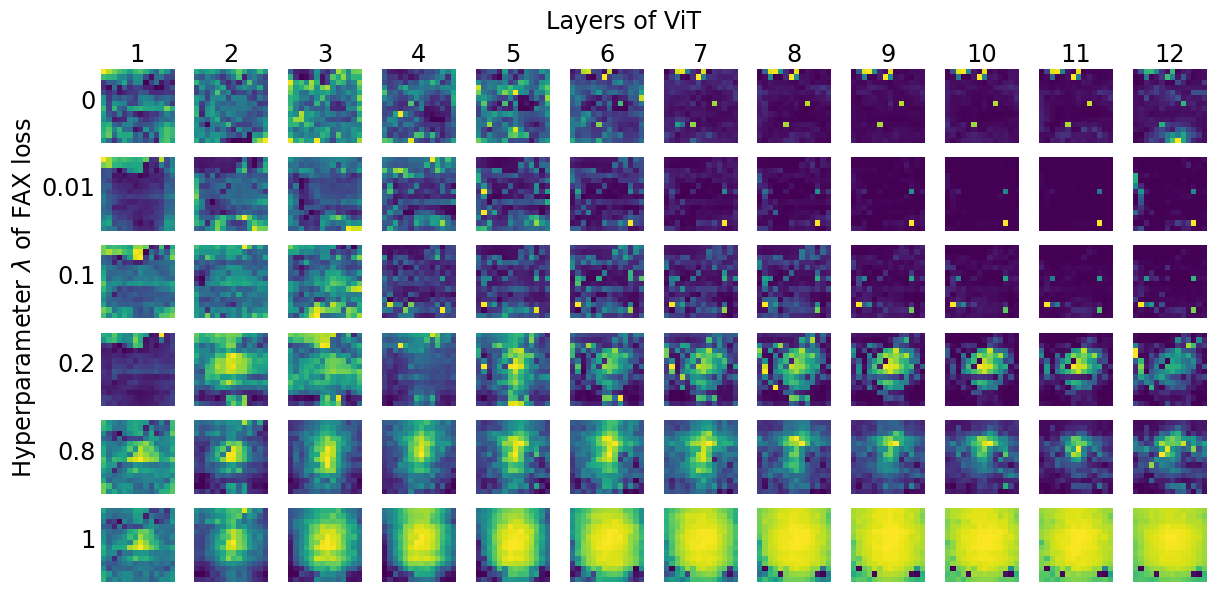

In [11]:
'''Plot attention maps of a given head for all layers for every 'lambda' value of the FAX loss'''
# Plot the test image
plot_sample_image(test_idx, 'fixation_overlaid', test_data)
plot_sample_image(test_idx, 'fixation_reduced', test_data)

attention_maps_list = attention_maps  # 5 arrays of shape (12, 14, 14)

# Define the lambda values and number of layers
lambda_values = [0, 0.01, 0.1, 0.2, 0.8, 1]
num_layers = 12
lambda_labels = [f"{l}" for l in lambda_values]

# Setup the figure and axes grid
fig, axes = plt.subplots(len(lambda_values), num_layers, figsize=(num_layers, len(lambda_values)))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# # Set the labels for lambda values (y-axis)
# for ax, lambda_value in zip(axes[:, 0], lambda_values):
#     ax.set_ylabel(f"{lambda_value}", size='x-large', rotation=0, labelpad=10)

for row, lambda_label in enumerate(lambda_labels):  # Reverse the layer labels
    axes[row, 0].annotate(lambda_label, xy=(0, 5.5), xytext=(-axes[row, 0].yaxis.labelpad - 1.5, 0),
                          textcoords='offset points', size='xx-large', ha='right', va='center')
                        #   rotation='vertical')  # Rotate the text vertically and use medium font size

# Set the labels for layers (x-axis)
for ax_col, layer_num in zip(axes[0], range(1, num_layers + 1)):
    ax_col.set_title(layer_num, size='xx-large')

# Plot the attention maps
for row, lambda_value in enumerate(lambda_values):
    for col in range(num_layers):
        ax = axes[row, col]
        attention_map = attention_maps_list[row][col]  # Note the change in indices
        ax.imshow(attention_map, cmap='viridis')
        ax.axis('off')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)

# Set the main titles for the axes
fig.text(0.5, 0.96, 'Layers of ViT', ha='center', va='center', size='xx-large')
fig.text(0, 0.5, 'Hyperparameter $\lambda$ of FAX loss', ha='center', va='center', rotation='vertical', size='xx-large')

plt.savefig(f'lambda_vs_layers.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
